In [1]:
from lib import utils
from lib import models
from lib import executor
from lib.utils import nearest_integer_acc

import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = '../data_files/sha/ecq_sha_B_100_conds_1_500000_reg.parquet'
df = utils.load_data(path)

# dropping columns that are not needed
df.drop(['conductor','adelic_level','lmfdb_label'], axis=1, inplace=True)

# get square root of order of sha
df['sqrt_sha'] = df['sha'].apply(lambda x: int(x**0.5))
df.drop('sha', axis=1, inplace=True)
print(f'Values counts of the square root of order of sha: ')
print(df.sqrt_sha.value_counts())

Loaded the dataset with 120 features and 3064705 curves..
Values counts of the square root of order of sha: 
1     2821178
2      158758
3       50428
4       18170
5        8501
6        2402
7        2153
8        1301
9         595
10        315
11        300
13        160
12        145
14         58
16         45
15         43
17         34
19         29
20         15
23         13
25         12
18          7
28          7
21          5
32          4
27          4
24          4
26          3
29          3
31          3
22          2
41          1
75          1
50          1
47          1
33          1
43          1
37          1
34          1
Name: sqrt_sha, dtype: int64


In [3]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_9 = df[df['sqrt_sha'] == 3].shape[0]
df_balanced = df[df['sqrt_sha'] == 2].sample(len_9) 
df_balanced = pd.concat([df_balanced, df[df['sqrt_sha'] == 3]])
print(f'Values counts of the square root of order of sha: ')
df_balanced.sqrt_sha.value_counts()

Values counts of the square root of order of sha: 


2    50428
3    50428
Name: sqrt_sha, dtype: int64

In [4]:
# Select your features

# BSD Features
df_BSD = df_balanced[['special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sqrt_sha']]

# fix the seed for reproducibility
seed = 42

# first run an experiment using all variables from BSD formula

In [5]:
# choose model parameters
hidden_units = [128,64,32]

# check if we have cuda available
device = utils.get_device()

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_BSD, 'sqrt_sha', if_regression=True)

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.3, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

Device: cpu.
The input dimension is 5 and the output dimension is 1.
The model has 11,585 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [6]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 100
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = nearest_integer_acc

Save the model from epoch 96 with Training MSELoss : 0.0051, Validation MSELoss : 0.0050. Training nearest_integer_acc : 0.9832, Validation nearest_integer_acc : 0.9818, to ..\trained_models\model.pth.


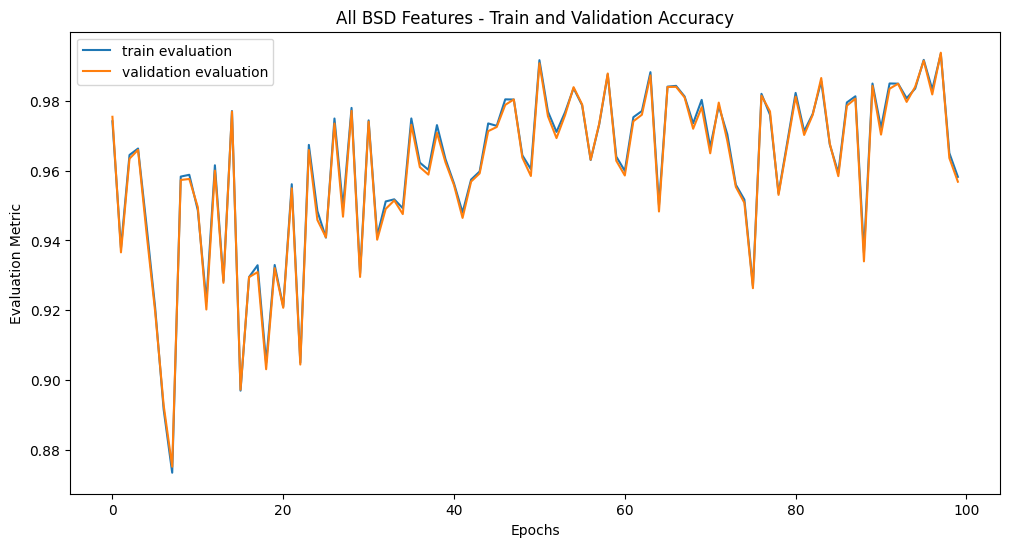

In [9]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_BSD, 'sqrt_sha', device, if_regression=True, random_state=seed)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=False)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist, title='All BSD Features - Train and Validation Accuracy')

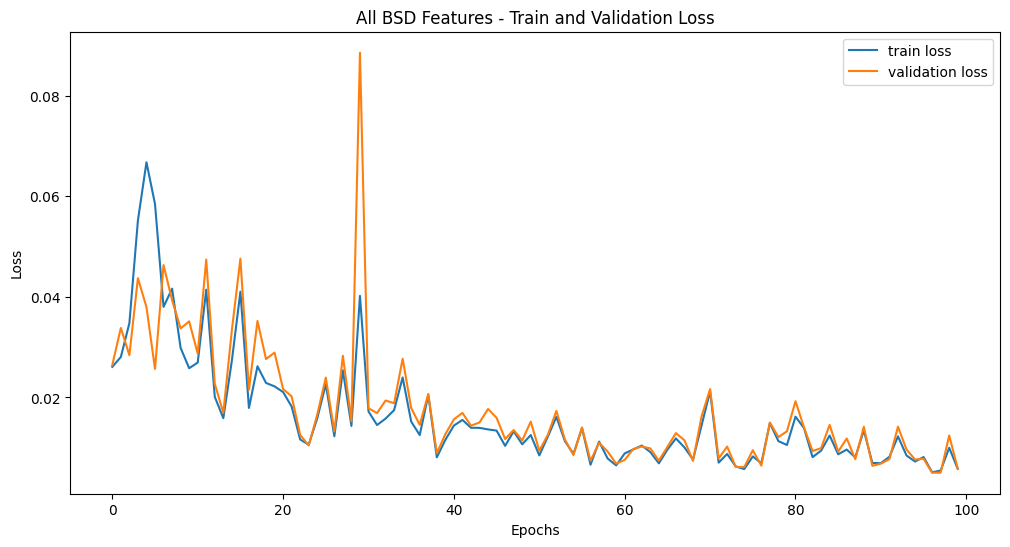

In [10]:
utils.plot_train_loss_hist(train_loss_hist, val_loss_hist, title='All BSD Features - Train and Validation Loss')

In [11]:
acc = executor.test(model, test_dataset, evaluator, if_regression = True)
mae = executor.test(model, test_dataset, mean_absolute_error, if_regression = True)
mse = executor.test(model, test_dataset, mean_squared_error, if_regression = True)
print(f"Test accuracy: {acc:0.4f}")
print(f"Test Mean Absolute Error: {mae:0.4f}. Test Mean Squared Error: {mse:0.4f}")

Test accuracy: 0.9836
Test Mean Absolute Error: 0.0452. Test Mean Squared Error: 0.0427


# now delete one feature per time to test feature importance

In [12]:
# write a list of lists where each list is taking one feature out
# this is for the purpose of feature importance
features = ['special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product']
features_list = []
missing_feature = []
for i in range(len(features)):
    missing_feature.append(features[i])
    features_list.append([x for x in features if x != features[i]]+['sqrt_sha'])

Running model without special_value..
The input dimension is 4 and the output dimension is 1.
Save the model from epoch 89 with Training MSELoss : 0.1870, Validation MSELoss : 0.1882. Training nearest_integer_acc : 0.7056, Validation nearest_integer_acc : 0.7040, to ..\trained_models\model.pth.
Test accuracy: 0.7010
Test Mean Absolute Error: 0.3903. Test Mean Squared Error: 0.1927
----------------------------------
Running model without torsion..
The input dimension is 4 and the output dimension is 1.


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_20768\1774551502.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature Deleted': missing_feature[i], 'Accuracy': acc.item(), 'MAE': mae, 'MSE': mse}, ignore_index=True)


Save the model from epoch 92 with Training MSELoss : 0.0290, Validation MSELoss : 0.0277. Training nearest_integer_acc : 0.9608, Validation nearest_integer_acc : 0.9632, to ..\trained_models\model.pth.
Test accuracy: 0.9594
Test Mean Absolute Error: 0.0980. Test Mean Squared Error: 0.0350
----------------------------------
Running model without regulator..
The input dimension is 4 and the output dimension is 1.


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_20768\1774551502.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature Deleted': missing_feature[i], 'Accuracy': acc.item(), 'MAE': mae, 'MSE': mse}, ignore_index=True)


Save the model from epoch 61 with Training MSELoss : 0.0256, Validation MSELoss : 0.0187. Training nearest_integer_acc : 0.9658, Validation nearest_integer_acc : 0.9647, to ..\trained_models\model.pth.
Test accuracy: 0.9651
Test Mean Absolute Error: 0.0714. Test Mean Squared Error: 0.0304
----------------------------------
Running model without real_period..
The input dimension is 4 and the output dimension is 1.


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_20768\1774551502.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature Deleted': missing_feature[i], 'Accuracy': acc.item(), 'MAE': mae, 'MSE': mse}, ignore_index=True)


Save the model from epoch 94 with Training MSELoss : 0.2238, Validation MSELoss : 0.2233. Training nearest_integer_acc : 0.6302, Validation nearest_integer_acc : 0.6320, to ..\trained_models\model.pth.
Test accuracy: 0.6347
Test Mean Absolute Error: 0.4520. Test Mean Squared Error: 0.2237
----------------------------------
Running model without tamagawa_product..
The input dimension is 4 and the output dimension is 1.


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_20768\1774551502.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature Deleted': missing_feature[i], 'Accuracy': acc.item(), 'MAE': mae, 'MSE': mse}, ignore_index=True)


Save the model from epoch 96 with Training MSELoss : 0.0794, Validation MSELoss : 0.0785. Training nearest_integer_acc : 0.8729, Validation nearest_integer_acc : 0.8730, to ..\trained_models\model.pth.
Test accuracy: 0.8699
Test Mean Absolute Error: 0.2482. Test Mean Squared Error: 0.1062
----------------------------------
    Feature Deleted  Accuracy       MAE       MSE
0     special_value  0.700972  0.390343  0.192720
1           torsion  0.959449  0.097990  0.034988
2         regulator  0.965150  0.071440  0.030399
3       real_period  0.634692  0.452044  0.223724
4  tamagawa_product  0.869919  0.248201  0.106204


C:\Users\Xiaoyu Huang\AppData\Local\Temp\ipykernel_20768\1774551502.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Feature Deleted': missing_feature[i], 'Accuracy': acc.item(), 'MAE': mae, 'MSE': mse}, ignore_index=True)


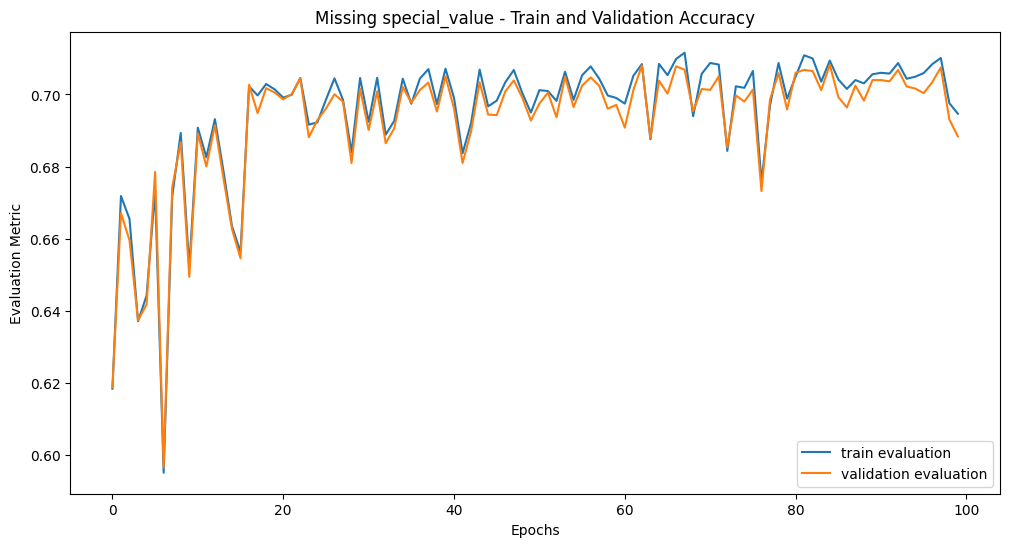

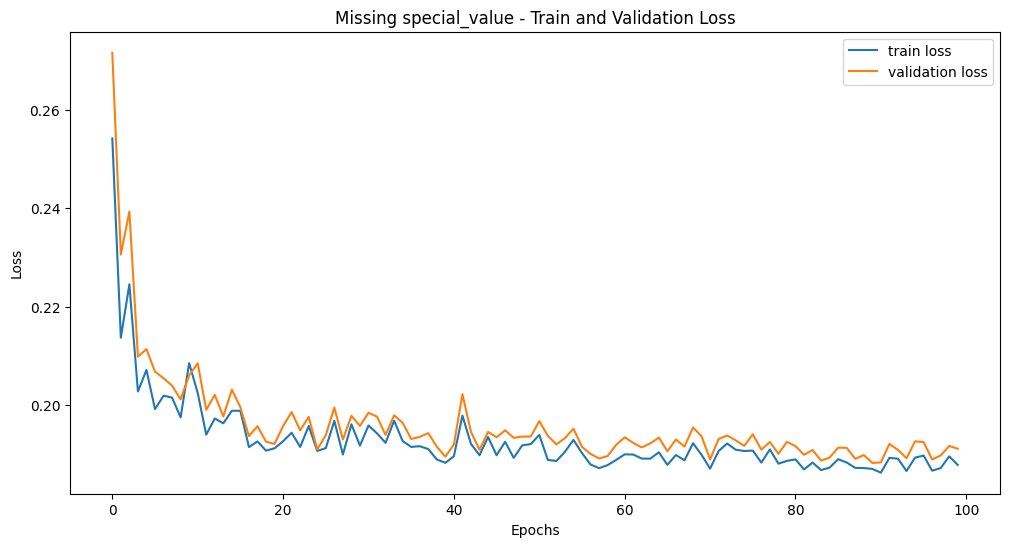

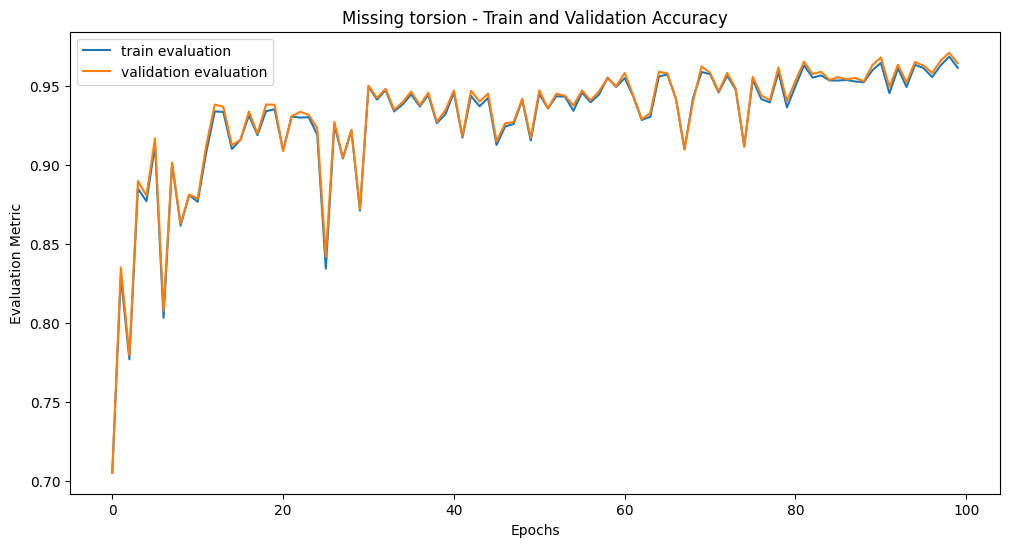

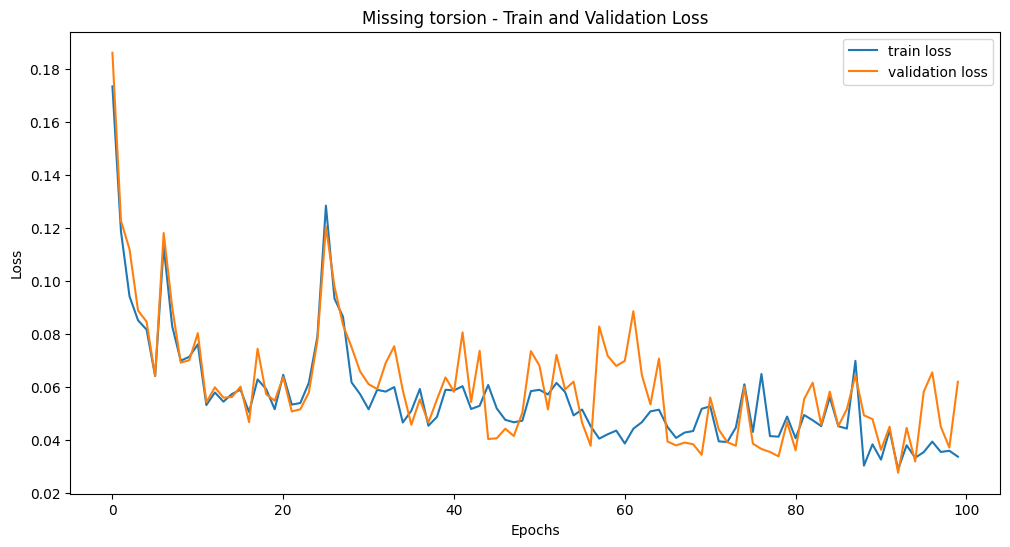

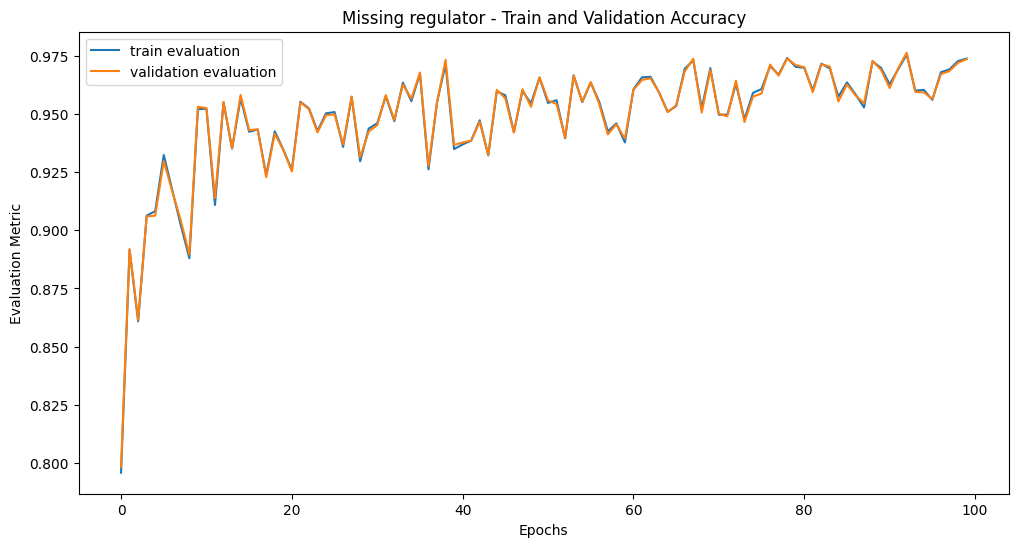

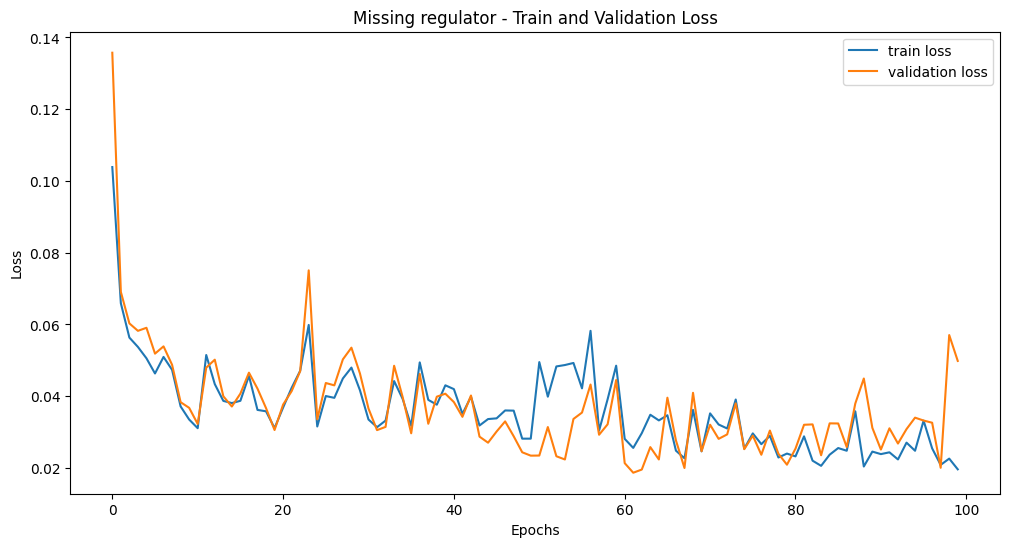

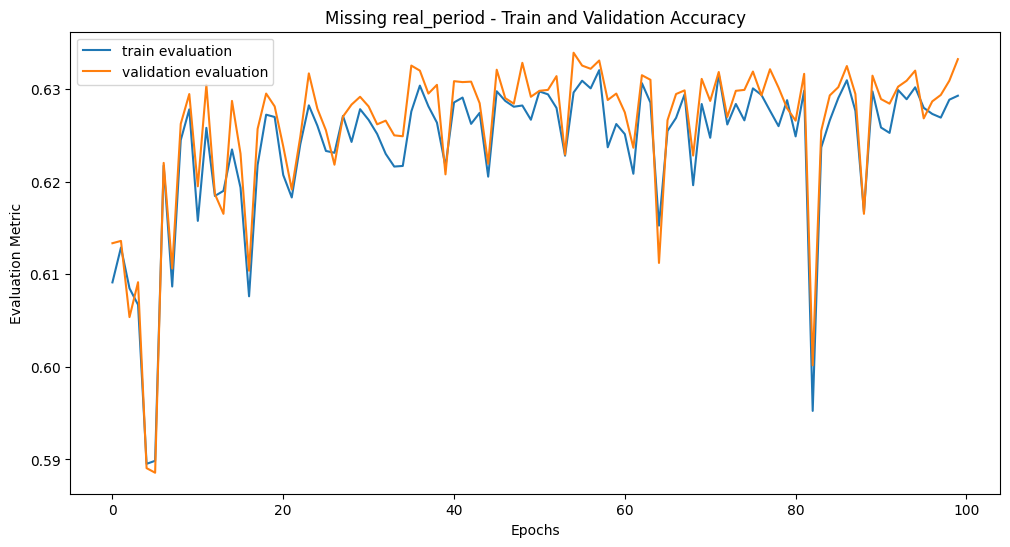

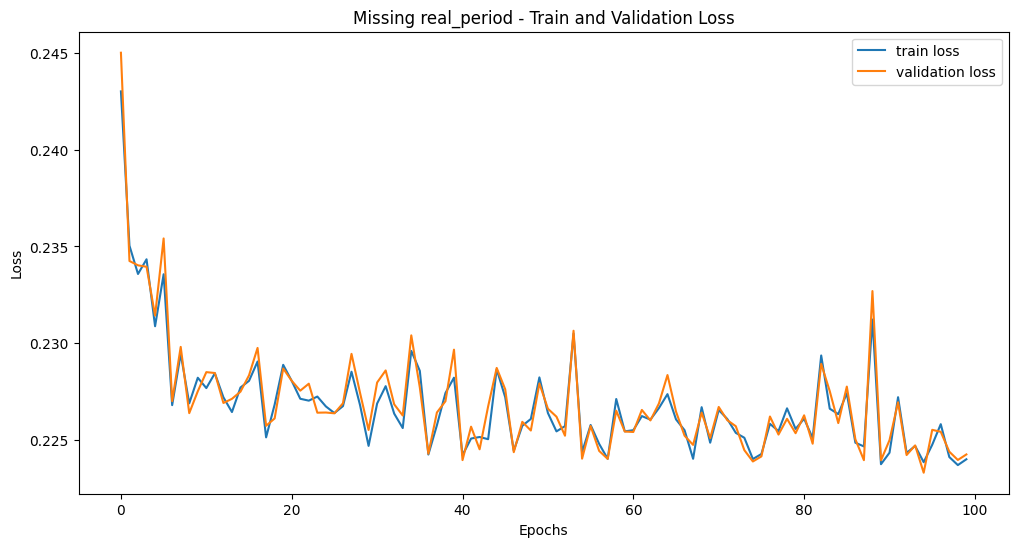

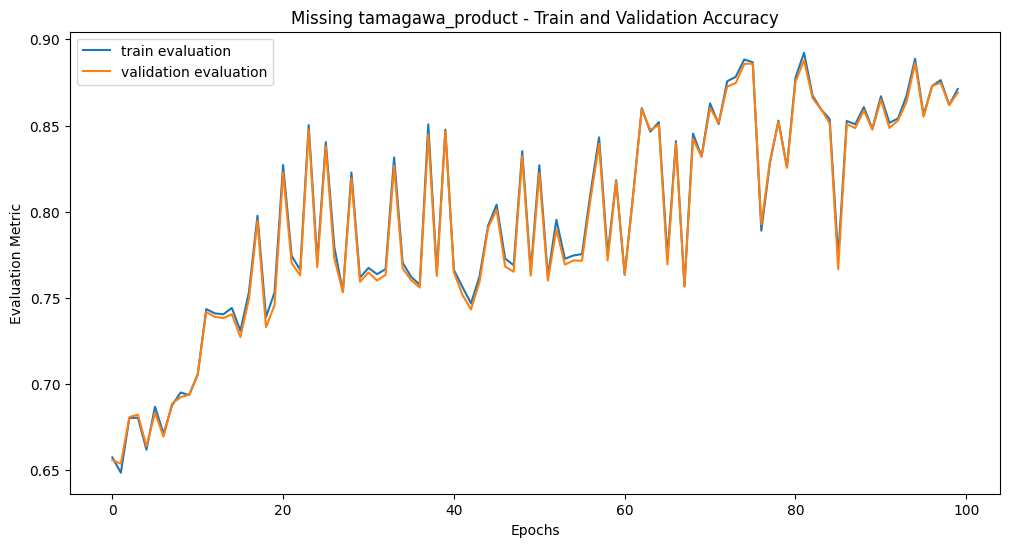

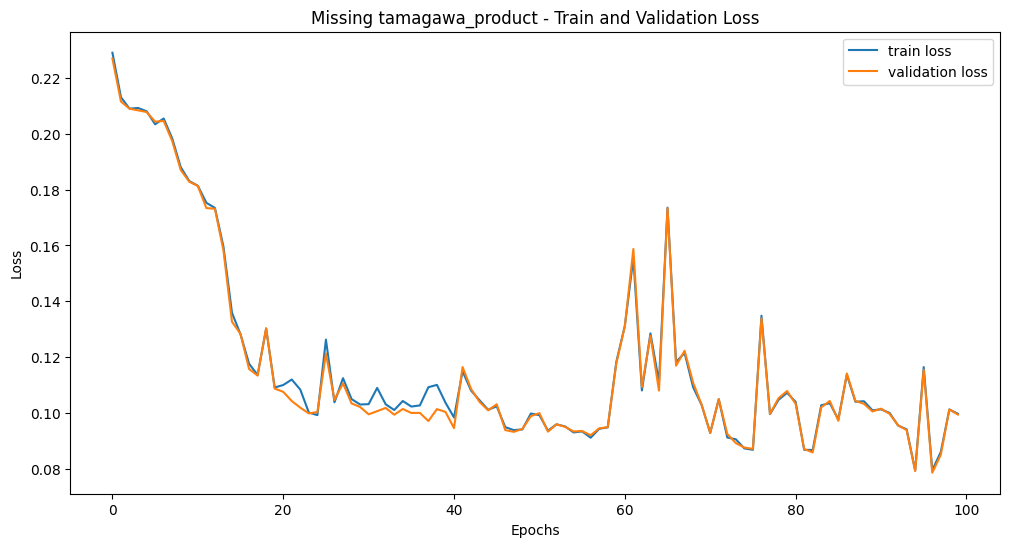

In [22]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature Deleted', 'Accuracy', 'MAE', 'MSE'])

for i in range(len(features_list)):
    print(f'Running model without {missing_feature[i]}..')
    df_sub = df_BSD.drop(columns=[missing_feature[i]])
    input_dim, output_dim = utils.get_input_output_dim(df_sub, 'sqrt_sha', if_regression=True)
    model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.3, if_batchnorm=True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) # reinitialize optimizer
    train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_sub, 'sqrt_sha', device, if_regression=True, random_state=seed)
    model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=False)
    # plot train_eval_hist, val_eval_hist
    utils.plot_train_eval_hist(train_eval_hist, val_eval_hist, title=f'Missing {missing_feature[i]} - Train and Validation Accuracy', show = False)
    utils.plot_train_loss_hist(train_loss_hist, val_loss_hist, title=f'Missing {missing_feature[i]} - Train and Validation Loss', show = False)
    acc = executor.test(model, test_dataset, evaluator, if_regression=True)
    mae = executor.test(model, test_dataset, mean_absolute_error, if_regression=True)
    mse = executor.test(model, test_dataset, mean_squared_error, if_regression=True)
    print(f"Test accuracy: {acc:0.4f}")
    print(f"Test Mean Absolute Error: {mae:0.4f}. Test Mean Squared Error: {mse:0.4f}")
    print('----------------------------------')
    
    # Append the results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([{'Feature Deleted': missing_feature[i], 'Accuracy': acc, 'MAE': mae, 'MSE': mse}])], ignore_index=True)

In [23]:
print(results_df)

    Feature Deleted  Accuracy       MAE       MSE
0     special_value  0.700972  0.390343  0.192720
1           torsion  0.959449  0.097990  0.034988
2         regulator  0.965150  0.071440  0.030399
3       real_period  0.634692  0.452044  0.223724
4  tamagawa_product  0.869919  0.248201  0.106204
